In [1]:
import os
import warnings

import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import mplfinance as mpf
from mrs_class import *

plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore")

In [2]:
def read_file(dir_list, folder_path):
    file_list=[]
    for filename in dir_list: 
        file_list.append(pd.read_csv(folder_path + filename))

    df = pd.concat(file_list)
    df.reset_index(inplace = True, drop = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace = True, drop = True)
    return df

In [3]:
folder_path = 'E:\\Database\\Crypto data\\_coin_api\\'
dir_list = os.listdir(folder_path)
# print(dir_list)
df = read_file(dir_list, folder_path)

In [4]:
processed_data = mrsPreprocess(df, lag=2)

In [5]:
train, test = processed_data.split_train_test(col = ['ret', 'lag_1_ret', 'lag_2_ret', 'close'])

In [14]:
processed_data.df

,open,high,low,close,volume,trade_count,pricechange,ret,lag_1_ret,lag_2_ret
Date,,,,,,,,,,
2021-03-01 00:20:00,1422.05,1445.86,1421.64,1444.39,12078.550776,10383,22.39,0.015623,0.002753,0.002457
2021-03-01 00:25:00,1444.39,1449.01,1437.46,1442.32,6865.300284,7554,-2.07,-0.001434,0.015623,0.002753
2021-03-01 00:30:00,1442.54,1443.00,1438.49,1438.89,2008.812064,3419,-3.43,-0.002381,-0.001434,0.015623
2021-03-01 00:35:00,1438.89,1449.79,1438.89,1446.91,4863.866163,6500,8.02,0.005558,-0.002381,-0.001434
2021-03-01 00:40:00,1447.06,1448.11,1442.55,1443.84,2213.011471,3728,-3.07,-0.002124,0.005558,-0.002381
...,...,...,...,...,...,...,...,...,...,...
2021-05-22 23:40:00,2336.98,2336.98,2306.12,2311.32,4862.917895,10744,-25.45,-0.010951,-0.004330,-0.004417
2021-05-22 23:45:00,2311.32,2326.92,2306.44,2313.53,3200.627020,7529,2.21,0.000956,-0.010951,-0.004330
2021-05-22 23:50:00,2313.52,2313.66,2297.67,2302.66,2753.448844,7400,-10.87,-0.004710,0.000956,-0.010951


## HMM - Gaussian mixture model - on return, lag 1, lag 2

In [6]:
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import datetime as dt

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns

In [8]:
# X_train = train[["date", "return", "range", "close"]].set_index("date")
# X_test = test[["date", "return", "range", "close"]].set_index("date")

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(train[['ret', 'lag_1_ret', 'lag_2_ret']])

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(test[['ret', 'lag_1_ret', 'lag_2_ret']])

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

Means and vars of each hidden state
0th hidden state
mean =  [4.38846759e-05 7.77891720e-05 7.95922442e-05]
var =  [5.52566293e-06 5.97789898e-06 5.85566464e-06]

1th hidden state
mean =  [-1.34351094e-04 -5.03278480e-05  2.22367494e-04]
var =  [1.93373505e-05 1.22948154e-05 1.49630495e-05]

2th hidden state
mean =  [ 4.07045672e-04 -2.51558070e-05 -5.01750296e-04]
var =  [4.28984538e-05 5.12155337e-05 4.73655585e-05]



In [12]:
model.precisions_

array([[[183242.61286453,  18361.40679004,   8471.04168522],
        [ 18361.40679004, 170072.54472133,  13620.96928476],
        [  8471.04168522,  13620.96928476, 172136.06690942]],

       [[ 52014.27603998,  -4034.38809406,  -2954.34091306],
        [ -4034.38809406,  82266.11824839,   6680.69441719],
        [ -2954.34091306,   6680.69441719,  67506.98001678]],

       [[ 23502.78956158,  -1232.49314305,   1690.67348628],
        [ -1232.49314305,  19771.12565575,  -2053.43965029],
        [  1690.67348628,  -2053.43965029,  21429.89845617]]])

findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


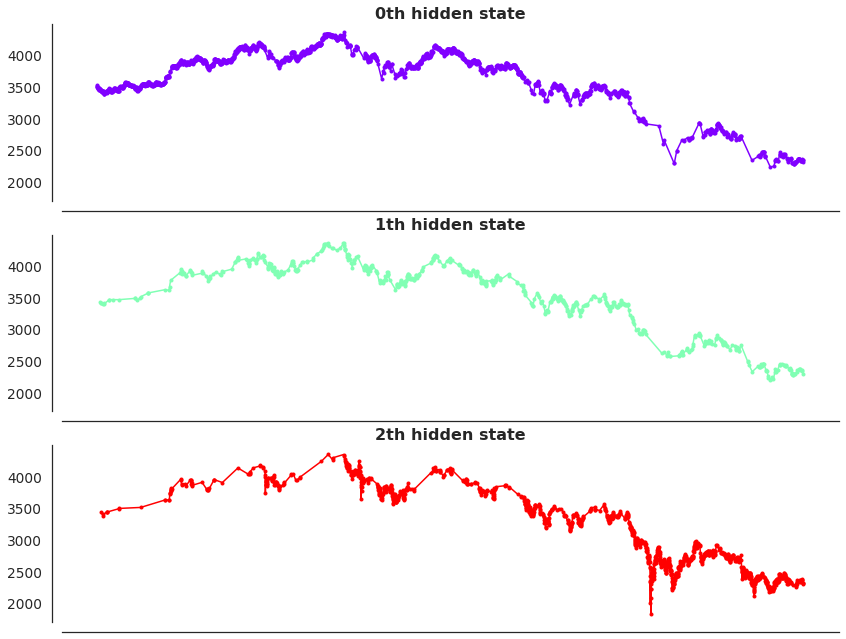

In [9]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(test.index.values[mask],
                 test['close'].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()

findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


Text(0.5, 0.98, 'ETH Regimes')

findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


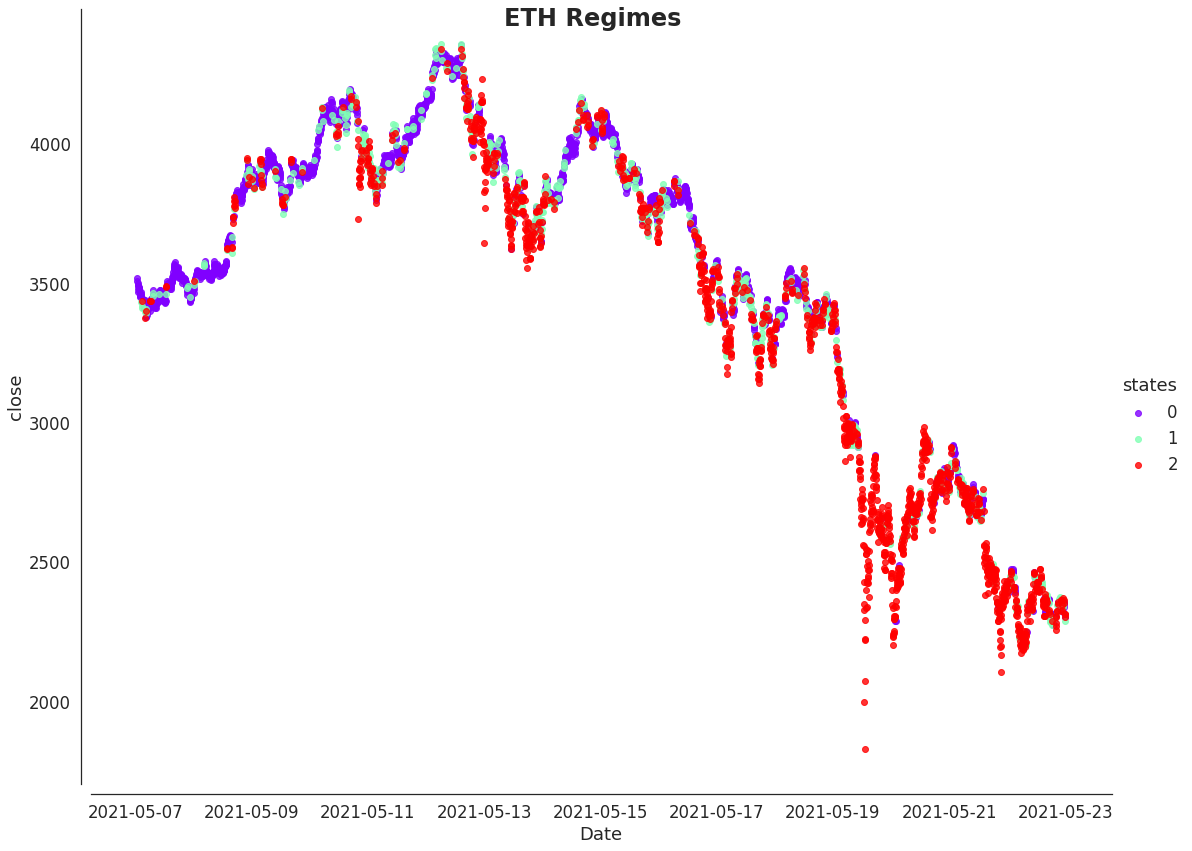

In [10]:

sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=test.index)
          .join(test, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
states.head()

#suppressing warnings because of some issues with the font package
#in general, would not rec turning off warnings.
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', 'close', alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('ETH Regimes', fontsize=24, fontweight='demi')

## MRS regression

In [ ]:
group_df_train = train.groupby([train.index.hour, train.index.minute]).mean()
# train = create_variable(group_df_train)
# train = train.droplevel(level = 0)
# train.reset_index(drop = True, inplace = True)
group_df_train.head()

group_df_test = test.groupby([test.index.hour, test.index.minute]).mean()
# test = create_variable(group_df_test)
# test = test.droplevel(level = 0)
# test.reset_index(drop = True, inplace = True)
group_df_test.head()

In [ ]:
endog_train, exog_train = train['ret'], train[['lag_1_ret', 'lag_2_ret']]
# endog_test, exog_test, exog_ochl_test = test['ret'], test[['lag1_ret','lag2_ret']], test[['volumeGap','fractHigh', 'fractLow']]

In [ ]:
# Include exog variables: lag 1, lag 2
mod = sm.tsa.MarkovRegression(endog=endog_train, k_regimes=2, exog=exog_train, trend = 'nc', switching_variance=True).fit()

In [ ]:
mod.summary()

In [ ]:
mod.smoothed_marginal_probabilities

In [ ]:
marginal_prob_regime1 = mod.smoothed_marginal_probabilities[0]
marginal_prob_regime2 = mod.smoothed_marginal_probabilities[1]

In [ ]:
grouped_df_1 = marginal_prob_regime1.groupby([marginal_prob_regime1.index.hour, marginal_prob_regime1.index.minute]).mean()

In [ ]:
grouped_df_1.plot()

In [ ]:
grouped_df_2 = marginal_prob_regime2.groupby([marginal_prob_regime2.index.hour, marginal_prob_regime2.index.minute]).mean()

In [ ]:
grouped_df_2.plot()

In [ ]:
# No exog variables
mod = sm.tsa.MarkovRegression(endog=endog_train, k_regimes=2, trend='nc', 
                            switching_trend=True,
                            switching_variance=True).fit()

In [ ]:
marginal_prob_regime1_model2 = mod.smoothed_marginal_probabilities[0]
marginal_prob_regime2_model2 = mod.smoothed_marginal_probabilities[1]

In [ ]:
grouped_df_1 = marginal_prob_regime1.groupby([marginal_prob_regime1.index.hour, marginal_prob_regime1.index.minute]).mean()

In [ ]:
mod.smoothed_marginal_probabilities[1].plot()

In [ ]:
mod.params

In [ ]:
    def betaMatrix(self):
        '''k*k beta matrix, each row contains one beta under each regime'''
        if self.exog is not None:
            params = self.mod.params
            xparam = params[params.index.str.contains('x')]
            nExog = int(len(xparam) / self.k)
            xparam = np.array(xparam).reshape(nExog, self.k)
            return xparam
        else:  
            return 0